In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu

# Result visualization

In [114]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # numer of iterations on confounder-based partitions
ct_sels = ['STAD', 'LUSC'] # string identifiers of cohorts
confs = ['age', 'sex', 'stage'] # string identifiers of confounders/variables
algs = ['ARACNE', 'CEMI', 'GENIE3', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms
alpha = 0.05

### Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [115]:
JI = pd.DataFrame(columns = ['confounder/\nvariable', 'cohort', 'method', 'partition type', 'partID', 'k', 'mean JI'])
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, 'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(n):
                filename = 'cb'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_conf = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_conf['partID'] = i
                    df_conf['partition type'] = 'confounder-based'
                    df_conf['method'] = alg_sel
                    df_conf['cohort'] = ct_sel
                    df_conf['confounder/\nvariable'] = conf_sel
                except:
                    continue
                filename = 'rnd'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_rnd = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_rnd['partID'] = i
                    df_rnd['partition type'] = 'random'
                    df_rnd['method'] = alg_sel
                    df_rnd['cohort'] = ct_sel
                    df_rnd['confounder/\nvariable'] = conf_sel
                except:
                    continue
                JI = pd.concat([JI, df_conf, df_rnd])
print(JI.head())

  confounder/\nvariable cohort  method    partition type partID    k  \
0                   age   STAD  ARACNE  confounder-based      0   10   
1                   age   STAD  ARACNE  confounder-based      0   60   
2                   age   STAD  ARACNE  confounder-based      0  110   
3                   age   STAD  ARACNE  confounder-based      0  160   
4                   age   STAD  ARACNE  confounder-based      0  210   

    mean JI  size intersection  size union      state  
0  0.176471                3.0        17.0  filled01_  
1  0.188119               19.0       101.0  filled01_  
2  0.176471               33.0       187.0  filled01_  
3  0.180812               49.0       271.0  filled01_  
4  0.179775               64.0       356.0  filled01_  


In [116]:
JI_all = JI.copy()
JI_all['confounder/\nvariable'] = JI_all['confounder/\nvariable'].replace(['race'], 'ethnicity')
confs = ['sex', 'age', 'stage']
JI_all = JI_all[JI_all['k']%100 == 10]

### 1) Plot mean JI over k per cohort and per confounder

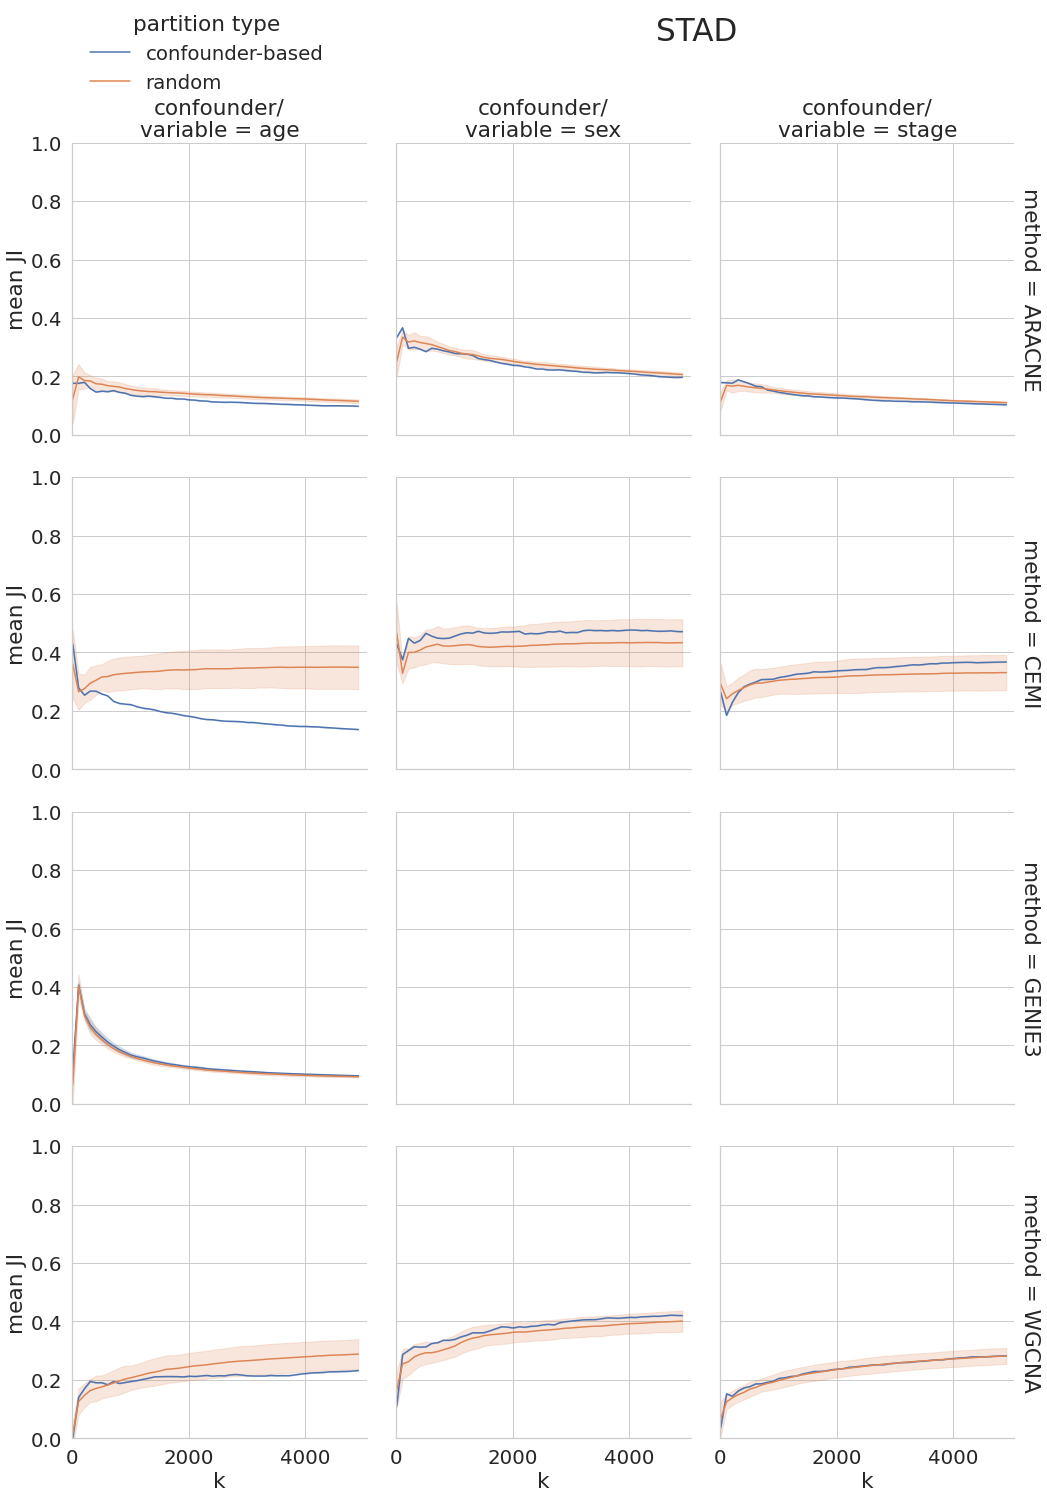

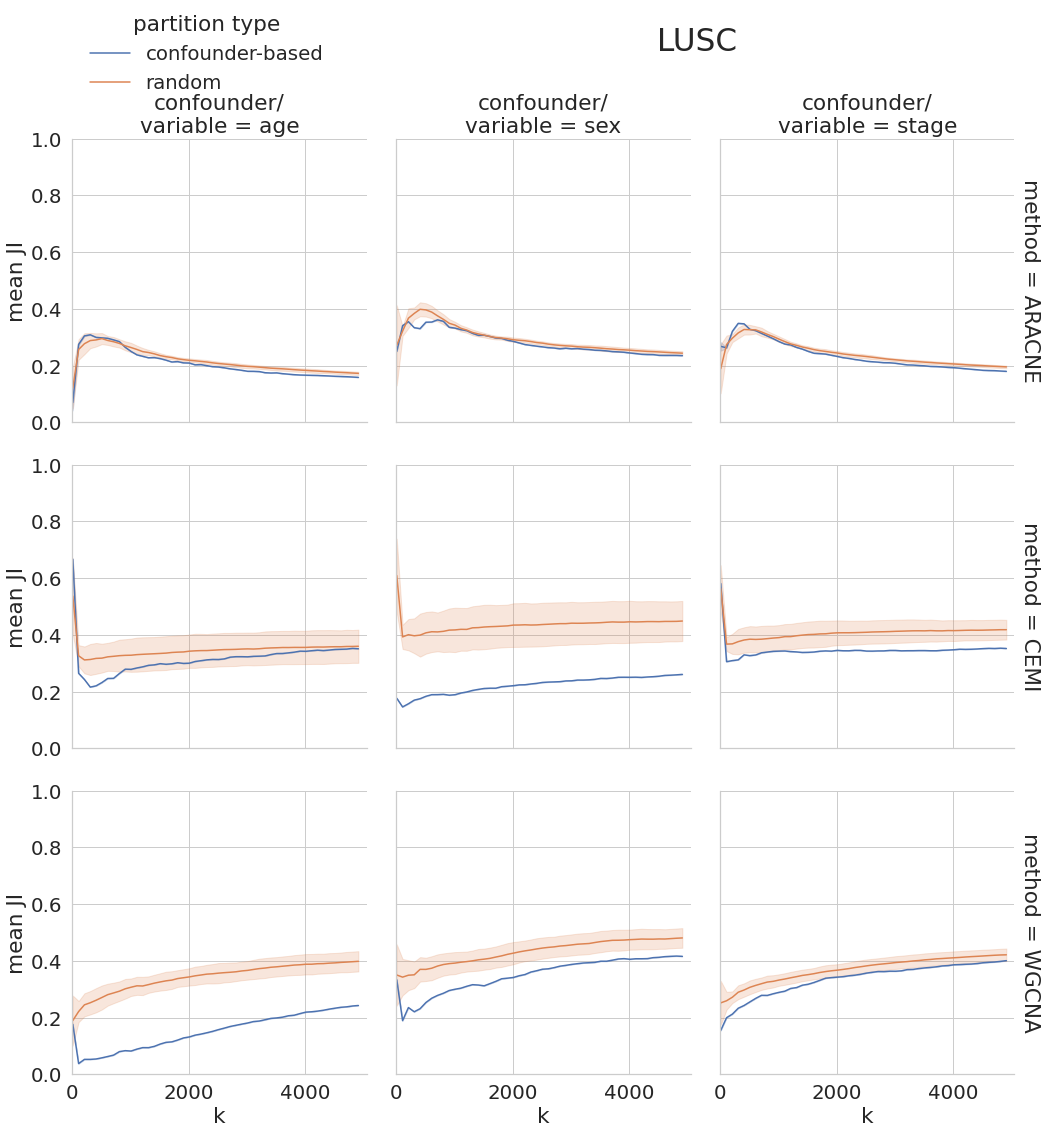

In [117]:
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
for ct_sel in ct_sels:
    JI = JI_all[JI_all['cohort'] == ct_sel]
    g = sns.FacetGrid(JI, row="method", col="confounder/\nvariable", hue='partition type', 
                      margin_titles=True, xlim=(0,5050), ylim=(0,1), legend_out=False, height=5)
    ax = g.axes[0,0]
    g.map(sns.lineplot, "k", "mean JI",errorbar='sd').add_legend()
    g.fig.suptitle(str(ct_sel), y=1.04, x=0.66, fontsize='x-large')
    sns.move_legend(ax, "upper left", frameon=False, bbox_to_anchor=(0.0, 1.5))
    

### test conf < rnd with one-sided Mann-Whitney-U  test for each k

In [121]:
mwus = pd.DataFrame(columns=['method', 'cohort', 'confounder/\nvariable', 'k', 'mwu.pvalue'])
for alg_sel in algs:
    JI = JI_all[JI_all['method'] == alg_sel]
    for cohort in ct_sels:
        coh = JI[JI['cohort'] == cohort]
        for conf_sel in confs:
            conf = coh[coh['confounder/\nvariable'] == conf_sel]
            if len(conf) == 0:
                continue
            c = conf[conf['partition type']=='confounder-based']
            r = conf[conf['partition type']=='random']
            for k in sorted(list(set(c['k']))):
                c_k = c[c['k'] == k]
                r_k = r[r['k'] == k]
                assert len(c_k) == len(r_k)
                mwu = mannwhitneyu(c_k['mean JI'],r_k['mean JI'], alternative='less')
                df = pd.DataFrame([[alg_sel, cohort, conf_sel, k, mwu.pvalue]], columns=['method', 'cohort', 'confounder/\nvariable', 'k', 'mwu.pvalue'])
                mwus = pd.concat([mwus, df])
mwus.reset_index(inplace=True)
mwus = mwus.drop('index', axis=1)
count = mwus.groupby(['method', 'cohort', 'confounder/\nvariable']).count()
sign = mwus[mwus['mwu.pvalue'] < alpha]
sign = sign.groupby(['method', 'cohort', 'confounder/\nvariable']).count()
sign['frac'] = sign['mwu.pvalue']/count['mwu.pvalue']

In [122]:
sign = sign.drop('mwu.pvalue', axis=1).drop('k', axis=1)

In [123]:
sign

frac
method cohort confounder/\nvariable      
ARACNE LUSC   age                    0.82
              sex                    0.76
              stage                  0.84
       STAD   age                    0.98
              sex                    0.74
              stage                  0.68
CEMI   LUSC   age                    0.18
              sex                    1.00
              stage                  0.98
       STAD   age                    0.92
              stage                  0.04
WGCNA  LUSC   age                    0.98
              sex                    0.98
              stage                  1.00
       STAD   age                    0.62
              sex                    0.02

In [124]:
import datetime
stamp = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
sign.to_csv(f'mwu_pvalues_{str(stamp)}.csv')

<Figure size 432x288 with 0 Axes>

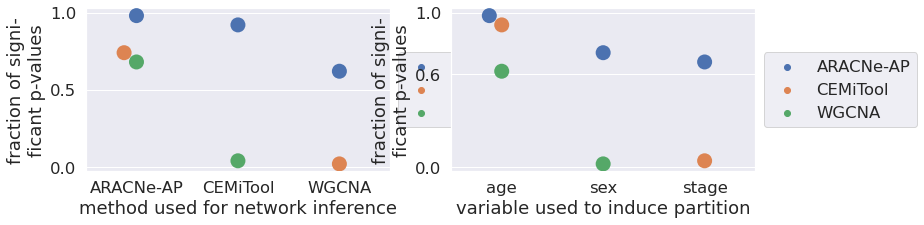

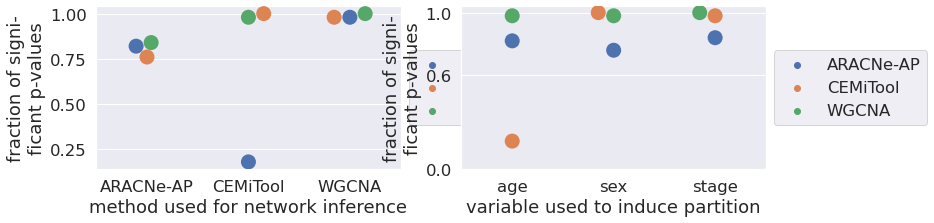

In [176]:
### UNDER CONSTRUCTION
plt.tight_layout()
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
_mwus = pd.DataFrame(sign).reset_index()
_mwus = _mwus.replace('ARACNE', 'ARACNe-AP').replace('CEMI', 'CEMiTool').replace('GRNBOOST2', 'GRNBoost2')
for ct_sel in ct_sels:
    h, axs_z = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw=dict(width_ratios=[10, 10]))

    cur = _mwus[_mwus['cohort'] == ct_sel]
    g = sns.swarmplot(ax=axs_z[0], x="method", y="frac",hue="confounder/\nvariable",data=cur, legend=True, s=15)
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    g.set(xlabel='method used for network inference', ylabel = "fraction of signi-\nficant p-values")
    plt.yticks([0.0, 0.6, 1.0])

    g = sns.swarmplot(ax=axs_z[1], x="confounder/\nvariable", y="frac",hue="method",data=cur, legend=True, s=15)
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    g.set(xlabel='variable used to induce partition', ylabel = "fraction of signi-\nficant p-values")
    plt.yticks([0.0, 0.6, 1.0])
fig = g.get_figure()
#h.savefig(os.path.join(cwd, 'mwu_comparison', str(cohort)+'_mwu_comparison.pdf'))
